# Prueba de conceptos

En este vamos a hacer una pruenba con 2 imagenes (Una por delante y la otra por detras), para demostrar los conceptos que usaremos en la implementacion.

## vamos a importar las imagenes

In [1]:
!pip install tqdm

In [31]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

(np.float64(-0.5), np.float64(3595.5), np.float64(2539.5), np.float64(-0.5))

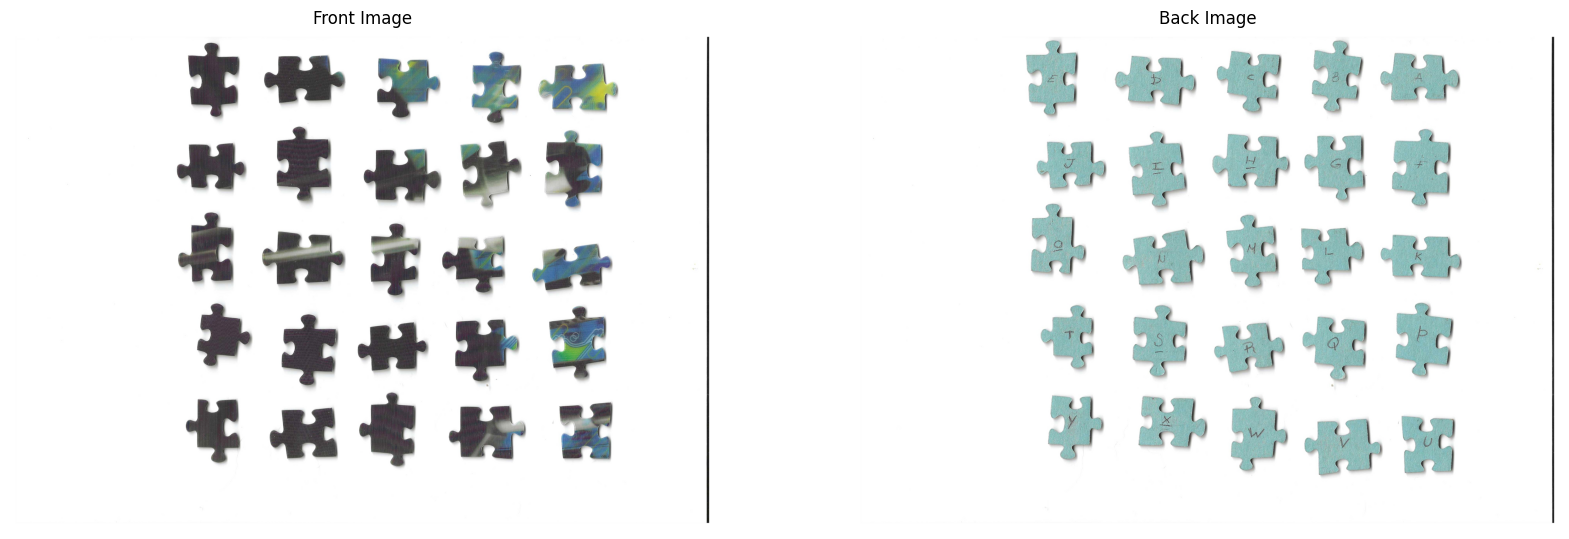

In [3]:
path = 'fotos/scan_25/'

front = cv.imread(path + 'front.jpg')
front = cv.rotate( front, cv.ROTATE_90_CLOCKWISE )
front = cv.copyMakeBorder(front, 30, 30, 30, 30, cv.BORDER_CONSTANT, value=[255, 255, 255])

back = cv.imread(path + 'back.jpg')
back = cv.rotate( back, cv.ROTATE_90_CLOCKWISE )
back = cv.copyMakeBorder(back, 30, 30, 30, 30, cv.BORDER_CONSTANT, value=[255, 255, 255])

front_gray = cv.cvtColor(front, cv.COLOR_BGR2GRAY)
back_gray = cv.cvtColor(back, cv.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(cv.cvtColor(front, cv.COLOR_BGR2RGB))
axes[0].set_title('Front Image')
axes[0].axis('off')
axes[1].imshow(cv.cvtColor(back, cv.COLOR_BGR2RGB))
axes[1].set_title('Back Image')
axes[1].axis('off')

## Segmentacion de las piezas

Como el fondo es banco uniforme, podemos usar un thresshold binario para segmentar las piezas del fondo, lo haremos con las piezas delanteras y traseras por separado.

(np.float64(-0.5), np.float64(3595.5), np.float64(2539.5), np.float64(-0.5))

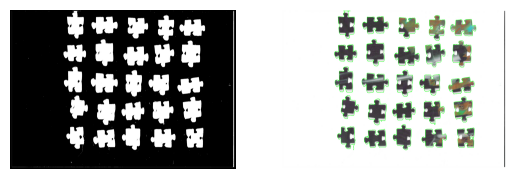

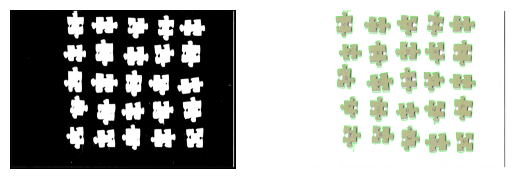

In [4]:
front_thresh = cv.threshold(front_gray, 250, 255, cv.THRESH_BINARY_INV)[1]
back_thresh = cv.threshold(back_gray, 250, 255, cv.THRESH_BINARY_INV)[1]

fig, ax = plt.subplots(1, 2)

plt.sca(ax[0])
plt.imshow(front_thresh, cmap='gray')
plt.axis('off')

front_contours , _ = cv.findContours(front_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
front_contours = sorted(front_contours, key=cv.contourArea, reverse=True)[:25]
front_segmented = front.copy()
contornos_in_original = cv.drawContours(front_segmented, front_contours, -1, (0, 255, 0), 3)

plt.sca(ax[1])
plt.imshow(contornos_in_original)
plt.axis('off')

fig, ax = plt.subplots(1, 2)

plt.sca(ax[0])
plt.imshow(front_thresh, cmap='gray')
plt.axis('off')

back_contours , _ = cv.findContours(back_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
back_contours = sorted(back_contours, key=cv.contourArea, reverse=True)[:25]
back_segmented = back.copy()
contornos_in_original = cv.drawContours(back_segmented, back_contours, -1, (0, 255, 0), 3)

plt.sca(ax[1])
plt.imshow(contornos_in_original)
plt.axis('off')

Como queremos guardar una asociacion entre piezas deleanteras y traseras vamos a reordenar las piezas segun su posicion asumineto que en las fotos estan formando una cuadricula 5 x 5.

In [5]:
def sort_contours(contours, imagen, ax = None):

    if ax != None:
        plt.sca(ax)
        plt.grid("off")

    ordered_contours = []


    centroids = np.array([np.mean(c.reshape(-1, 2), axis=0) for c in contours])
    x_centroids = centroids[:, 0]
    y_centroids = centroids[:, 1]

    # Hacemos un clustering para agrupar las coordenadas en 5 grupos
    x_prediction = sklearn.cluster.KMeans(n_clusters=5, random_state=0).fit(x_centroids.reshape(-1, 1))
    y_prediction = sklearn.cluster.KMeans(n_clusters=5, random_state=0).fit(y_centroids.reshape(-1, 1))

    # ploteamos la regilla generada para comprobar que es correcta
    plt.imshow(imagen)
    

    for i in range(5):
        plt.axvline(x=np.mean(x_centroids[x_prediction.labels_ == i]), color='black', linestyle='--')
        plt.axhline(y=np.mean(y_centroids[y_prediction.labels_ == i]), color='black', linestyle='--')

    plt.scatter(x_centroids, y_centroids, c=y_prediction.labels_ * 5, cmap='tab20')

    plt.title('Clustering de centroides')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid()

    cluster_centers_x = sorted(list(enumerate(x_prediction.cluster_centers_.flatten())), key=lambda x: x[1])
    cluster_centers_y = sorted(list(enumerate(y_prediction.cluster_centers_.flatten())), key=lambda x: x[1])

    for i, y_center in cluster_centers_y:
        for j, x_center in cluster_centers_x:
            index = np.where((y_prediction.labels_ == i) & (x_prediction.labels_ == j))[0][0]
            centroid = centroids[index]
            ordered_contours.append(contours[index])
            plt.text(centroid[0], centroid[1], f'{len(ordered_contours)}', color='red', fontsize=12)
    
    return ordered_contours

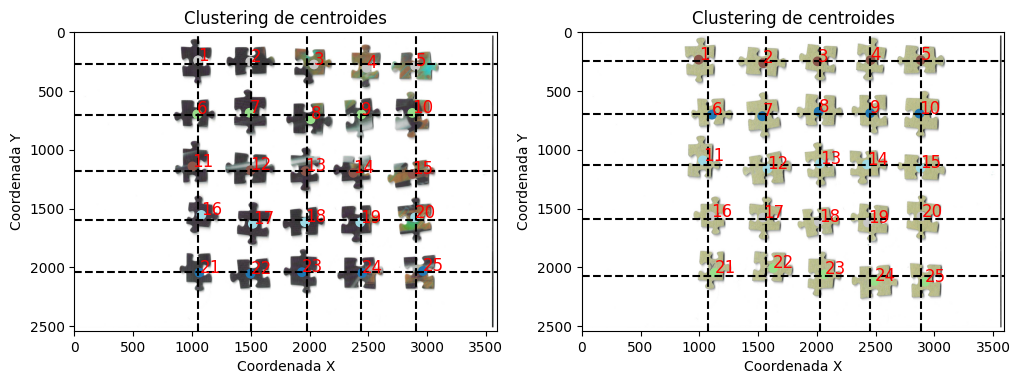

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

front_contours = sort_contours(front_contours, front, ax=axes[0])
back_contours = sort_contours(back_contours, back, ax=axes[1])

comprobamos que ahora el orden nos crea una asociacion correcta entre piezas delanteras y traseras.

A continuacino generamos los ROIS

In [7]:
front_rois = []

for contorno in front_contours:

    center = np.mean(contorno, axis=0).astype(int)
    max_x = np.max(contorno[:, 0, 0])
    min_x = np.min(contorno[:, 0, 0])
    max_y = np.max(contorno[:, 0, 1])
    min_y = np.min(contorno[:, 0, 1])

    pad = 20

    roi_front = front[min_y - pad:max_y + pad, min_x - pad:max_x + pad]
    front_rois.append(roi_front)

back_rois = []

for contorno in back_contours:

    center = np.mean(contorno, axis=0).astype(int)
    max_x = np.max(contorno[:, 0, 0])
    min_x = np.min(contorno[:, 0, 0])
    max_y = np.max(contorno[:, 0, 1])
    min_y = np.min(contorno[:, 0, 1])

    pad = 20

    roi_back = back[min_y - pad:max_y + pad, min_x - pad:max_x + pad]
    back_rois.append(roi_back)

Comprobamos que los ROIS son correctos

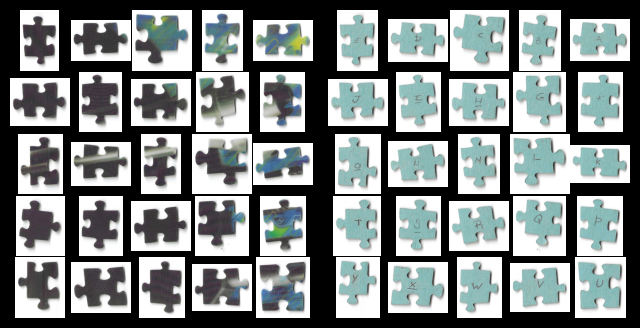

In [8]:
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(8, 4), facecolor='black')

outer_gs = gridspec.GridSpec(1, 2, wspace=0.05)

left_gs = gridspec.GridSpecFromSubplotSpec(
    5, 5, subplot_spec=outer_gs[0], wspace=0.02, hspace=0.02
)

for i in range(25):
    ax = fig.add_subplot(left_gs[i])
    ax.imshow(cv.cvtColor(front_rois[i], cv.COLOR_BGR2RGB))
    ax.axis('off')


right_gs = gridspec.GridSpecFromSubplotSpec(
    5, 5, subplot_spec=outer_gs[1], wspace=0.02, hspace=0.02
)

for i in range(25):
    ax = fig.add_subplot(right_gs[i])
    ax.imshow(cv.cvtColor(back_rois[i], cv.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

Una vez comprobado que los rois son correctos vamos a guardarlos enumerados en una carpeta.

In [9]:
for i, roi in enumerate(front_rois):
    cv.imwrite(f'fotos/segmented_scan_25/front/{i:02d}.png', roi)

for i, roi in enumerate(back_rois):
    cv.imwrite(f'fotos/segmented_scan_25/back/{i:02d}.png', roi)

# Deteccion de aristas y esquinas

vamos a tomar una sola pieza (vista desde atras) para hacer la deteccion de aristas y esquinas.

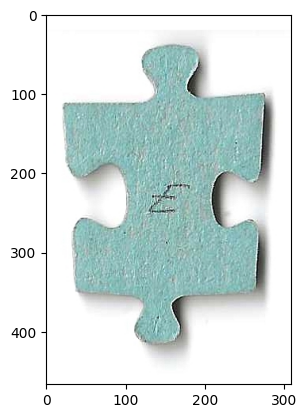

In [10]:
sample_piece = back_rois[0]
sample_piece_gray = cv.cvtColor(sample_piece, cv.COLOR_BGR2GRAY)

plt.imshow(cv.cvtColor(sample_piece, cv.COLOR_BGR2RGB))

## Grab Cut para segmentacion precisa

### Ajuste del margen.

haremos el rectangulo inicial con un thresholding muy basico ajustado pero asegurandolos de no cortar la pieza.

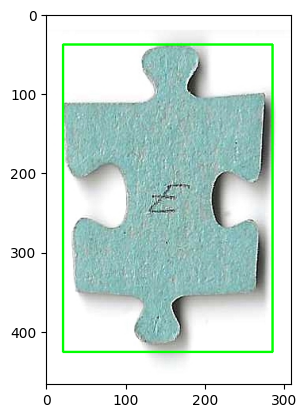

In [11]:
mask = cv.threshold(sample_piece_gray, 200, 255, cv.THRESH_BINARY_INV)[1]

minx = np.min(np.where(mask == 255)[1])
maxx = np.max(np.where(mask == 255)[1])
miny = np.min(np.where(mask == 255)[0])
maxy = np.max(np.where(mask == 255)[0])

rect = (minx, miny, maxx - minx, maxy - miny)

img = sample_piece.copy()
cv.rectangle(img, (minx, miny), (maxx, maxy), (0, 255, 0), 2)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

### matriz de planos.

mask

cv.GC_BGD, cv.GC_FGD, cv.GC_PR_BGD, cv.GC_PR_FGD, or simply pass 0,1,2,3 to image.

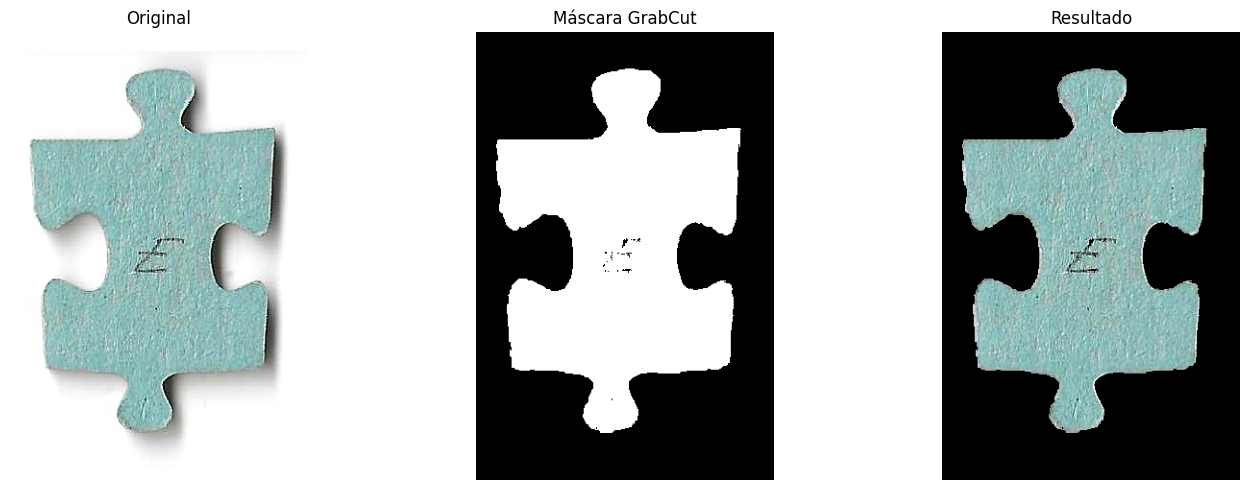

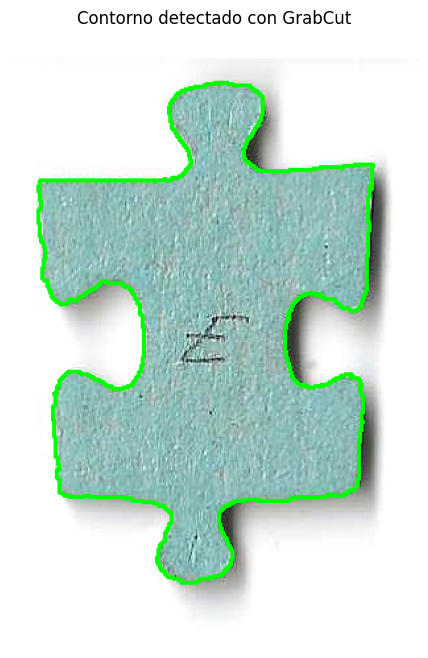

In [12]:
mask_gc = np.zeros(sample_piece.shape[:2], np.uint8)

# Definir rectángulo inicial (dejando margen del borde)
#margin = 25
#rect = (margin, margin, sample_piece.shape[1] - 2*margin, sample_piece.shape[0] - 2*margin)

# Modelos temporales para GrabCut
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

# Ejecutar GrabCut con rectángulo inicial
cv.grabCut(sample_piece,
           mask_gc,
           rect,
           bgd_model,
           fgd_model,
           50,
           cv.GC_INIT_WITH_RECT)

# Crear máscara binaria (0,2 = fondo, 1,3 = primer plano)
mask_result = np.where((mask_gc == 2) | (mask_gc == 0), 0, 1).astype('uint8')

# Aplicar máscara a la imagen
result = sample_piece * mask_result[:, :, np.newaxis]

# Visualizar resultados
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(cv.cvtColor(sample_piece, cv.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(mask_result, cmap='gray')
axes[1].set_title('Máscara GrabCut')
axes[1].axis('off')

axes[2].imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
axes[2].set_title('Resultado')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Obtener contorno de la máscara
contours_gc, _ = cv.findContours(mask_result, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
best_contour_gc = max(contours_gc, key=cv.contourArea)

# Dibujar contorno
img_contour = sample_piece.copy()
cv.drawContours(img_contour, [best_contour_gc], 0, (0, 255, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(img_contour, cv.COLOR_BGR2RGB))
plt.title('Contorno detectado con GrabCut')
plt.axis('off')
plt.show()

In [13]:
def apply_grabcut(image):
    def get_rect():
        mask = cv.threshold(cv.cvtColor(image, cv.COLOR_BGR2GRAY), 200, 255, cv.THRESH_BINARY_INV)[1]
        minx = np.min(np.where(mask == 255)[1])
        maxx = np.max(np.where(mask == 255)[1])
        miny = np.min(np.where(mask == 255)[0])
        maxy = np.max(np.where(mask == 255)[0])
        margin = 5
        return (minx - margin, miny - margin, maxx - minx + 2 * margin, maxy - miny + 2 * margin)

    rect = get_rect()

    mask_gc = np.zeros(image.shape[:2], np.uint8)

    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Subir a 50?

    cv.grabCut(image,
               mask_gc,
               rect,
               bgd_model,
               fgd_model,
               30,
                cv.GC_INIT_WITH_RECT)

    mask_result = np.where((mask_gc == 2) | (mask_gc == 0), 0, 1).astype('uint8')
    contours = cv.findContours(mask_result, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
    best_contour = max(contours, key=cv.contourArea)

    return best_contour

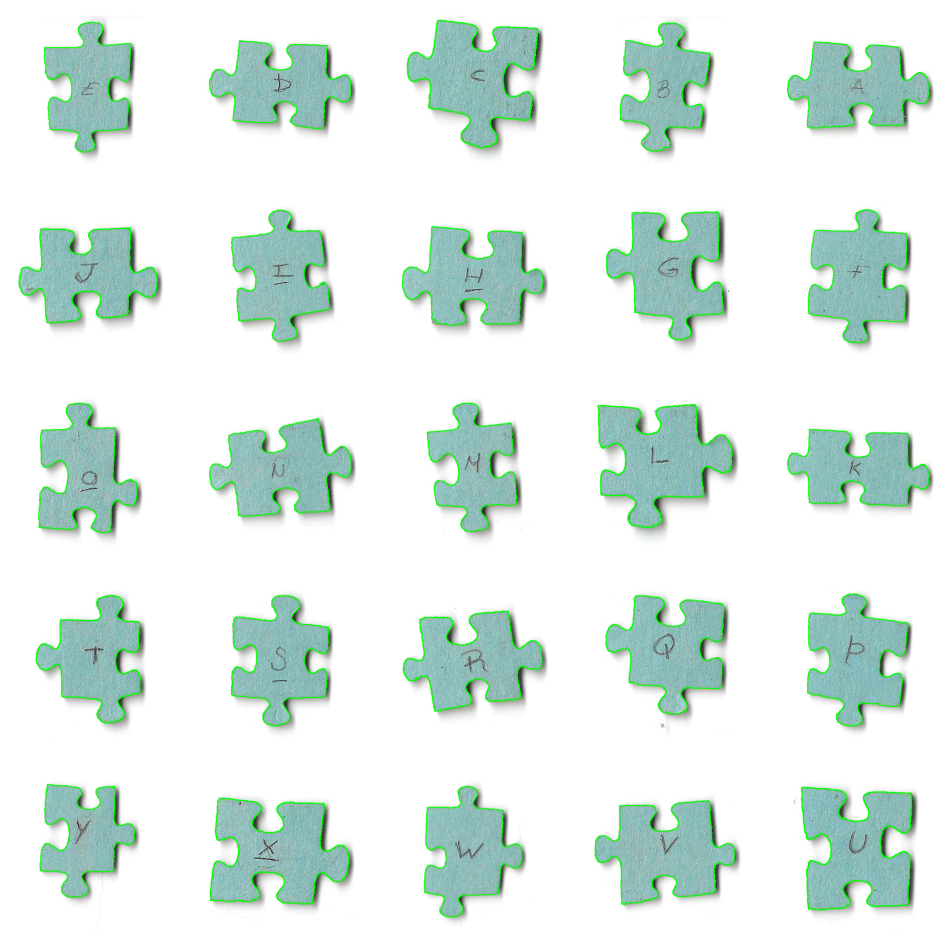

In [14]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()

masks = []
contours = []

for i in range(25):
    contour = apply_grabcut(back_rois[i])
    img_contour = back_rois[i].copy()
    cv.drawContours(img_contour, [contour], 0, (0, 255, 0), 2)
    axs[i].imshow(cv.cvtColor(img_contour, cv.COLOR_BGR2RGB))
    axs[i].axis('off')

    mask = cv.drawContours(np.zeros(back_rois[i].shape[:2], dtype=np.uint8), [contour], -1, 255, thickness=-1)

    masks.append(mask)
    contours.append(contour)


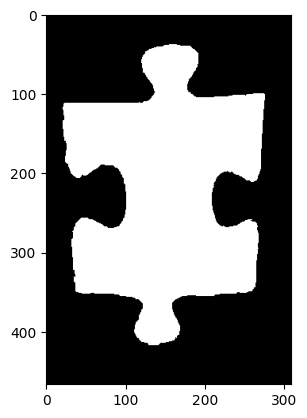

In [15]:
plt.imshow(masks[0], cmap='gray')

# Deteccion de esquinas de mask0



In [16]:
i = 1

In [17]:
import scipy
from scipy.signal import find_peaks

Text(0.5, 1.0, 'Función de distancia al centroide con picos')

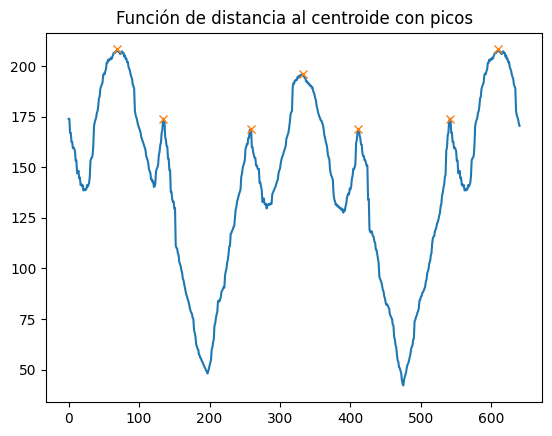

In [18]:
import scipy

centroide = np.mean(contours[i], axis=0).astype(int)
f_d_centroide = []

for punto in contours[i]:
    distancia = np.linalg.norm(punto - centroide)
    f_d_centroide.append(distancia)

f_d_centroide = f_d_centroide + f_d_centroide[:100]

peaks, _ = find_peaks(f_d_centroide, prominence=20)

plt.plot(f_d_centroide)
plt.plot(peaks, np.array(f_d_centroide)[peaks], "x")
plt.title('Función de distancia al centroide con picos')

In [19]:
reindexed_peaks = list(set([peak % len(contours[i]) for peak in peaks]))
peaks = reindexed_peaks


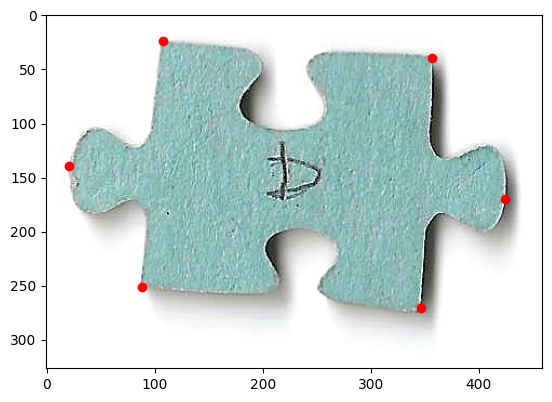

In [20]:
cords_picos = contours[i][peaks]
plt.imshow(cv.cvtColor(back_rois[i], cv.COLOR_BGR2RGB))
plt.scatter(cords_picos[:, 0, 0], cords_picos[:, 0  , 1], color='red')

In [21]:
from itertools import combinations

i_posible_squares = list(combinations(cords_picos, 4))

def loss_square(esquinas: list[np.ndarray]) -> float:
    # Calcula una funciona de puntuacion para un cuadrado dado sus esquinas cuanto mas bajo mejor

    v_aristas = []
    for i in range(4):
        p1 = esquinas[i][0]
        p2 = esquinas[(i + 1) % 4][0]
        v_aristas.append(p2 - p1)

    loss = 0.0

    for i in range(4):
        v1 = v_aristas[i]
        v2 = v_aristas[(i + 1) % 4]

        # Sacare el sono del angulo

        cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        loss += cos_theta ** 2 


    return loss

best_square = None

for esquinas in i_posible_squares:
    score = loss_square(esquinas)
    if best_square is None or score < best_square[0]:
        best_square = (score, esquinas)

print(f'Mejor cuadrado con loss: {best_square[0]}') 

Mejor cuadrado con loss: 0.2379638634434438


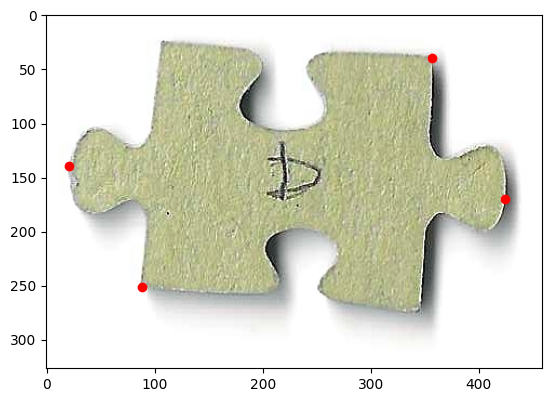

In [22]:
plt.imshow(back_rois[i], cmap='gray')
plt.scatter(*zip(*[esquina[0] for esquina in best_square[1]]), color='red')

In [23]:
!pip install shapely

In [24]:
def loss_square(esquinas: list[np.ndarray], c1: float = 1.0, c2: float = 1.0) -> float:
        # Calcula una funciona de puntuacion para un cuadrado dado sus esquinas cuanto mas bajo mejor

        v_aristas = []
        for i in range(4):
            p1 = esquinas[i][0]
            p2 = esquinas[(i + 1) % 4][0]
            v_aristas.append(p2 - p1)

        loss = 0.0

        for i in range(4):
            v1 = v_aristas[i]
            v2 = v_aristas[(i + 1) % 4]

            # Sacare el sono del angulo

            cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
            loss += cos_theta ** 2

        loss = loss * 2

        # penalizacion varianza longitudes lados
        lengths = [np.linalg.norm(v) for v in v_aristas]
        varianza = np.var(lengths)

        loss += alpha * varianza

        # penalizacion area.
        area = cv.contourArea( esquinas )

        loss -= beta * area

        print(f'Loss: {loss}, Varianza lados: {varianza}, Area: {area}, penalizacion area: {beta * area}')


        return loss

In [ ]:
def ordenar_esquinas_circular(esquinas, centroide):
    """Ordena las esquinas en sentido antihorario respecto al centroide"""
    def angulo(punto):
        return np.arctan2(punto[0][1] - centroide[0][1], punto[0][0] - centroide[0][0])
    return sorted(esquinas, key=angulo)

def loss_square(esquinas: list[np.ndarray], centroide, c1 = 1, c2 = 1, verbose=False) -> float:
        # Primero ordenamos las esquinas en sentido circular
        esquinas = ordenar_esquinas_circular(list(esquinas), centroide)
        
        # Calcula una funcion de puntuacion para un cuadrado dado sus esquinas cuanto mas bajo mejor
        v_aristas = []
        for i in range(4):
            p1 = esquinas[i][0]
            p2 = esquinas[(i + 1) % 4][0]
            v_aristas.append(p2 - p1)

        # Penalizacion angulos (queremos 90 grados, cos(90) = 0)
        loss_angulos = 0.0
        for i in range(4):
            v1 = v_aristas[i]
            v2 = v_aristas[(i + 1) % 4]
            cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
            loss_angulos += cos_theta ** 2

        # Penalizacion varianza longitudes lados
        lengths = [np.linalg.norm(v) for v in v_aristas]
        varianza_lados = np.var(lengths)
        loss_varianza = c1 * varianza_lados

        # Penalizacion distancia vertice-centroide
        distancias = [np.linalg.norm(esquina - centroide) for esquina in esquinas]
        varianza_distancias = np.var(distancias)
        loss_centroide = c2 * varianza_distancias

        loss = loss_angulos + loss_varianza + loss_centroide

        if verbose:
            print(f'Loss total: {loss:.4f} | Angulos: {loss_angulos:.4f} | Varianza lados (c1={c1}): {loss_varianza:.4f} | Varianza centroide (c2={c2}): {loss_centroide:.4f}')
            print(f'Longitudes lados: {[f"{l:.1f}" for l in lengths]}')

        return loss

In [26]:
def find_corners(contour: np.ndarray, c1, c2, verbose=False) -> list[np.ndarray]:
    # Sacamos el centroide
    centroide = np.mean(contour, axis=0).astype(int)
    f_d_centroide = []

    for punto in contour:
        distancia = np.linalg.norm(punto - centroide)
        f_d_centroide.append(distancia)

    f_d_centroide = f_d_centroide + f_d_centroide[:100]

    # Picos candidatos
    peaks, _ = find_peaks(f_d_centroide, prominence=20)
    reindexed_peaks = list(set([peak % len(contour) for peak in peaks]))
    peaks = reindexed_peaks

    i_posible_squares = list(combinations(peaks, 4))

    best_square = None

    for i_esquinas in i_posible_squares:
        esquinas = contour[list(i_esquinas)]
        score = loss_square(esquinas, centroide, c1, c2, verbose=False)
        if best_square is None or score < best_square[0]:
            best_square = (score, esquinas)

    # Mostrar desglose solo del mejor resultado
    if verbose:
        loss_square(best_square[1], centroide, c1, c2, verbose=True)

    return np.reshape(best_square[1], (-1, 2))

Loss total: 7.3893 | Angulos: 0.0006 | Varianza lados (c1=0.01): 2.5448 | Varianza centroide (c2=0.02): 4.8439
Longitudes lados: ['243.1', '214.8', '248.3', '213.2']


Text(0.5, 1.0, 'Esquinas detectadas con c1=0.01 y c2=0.02')

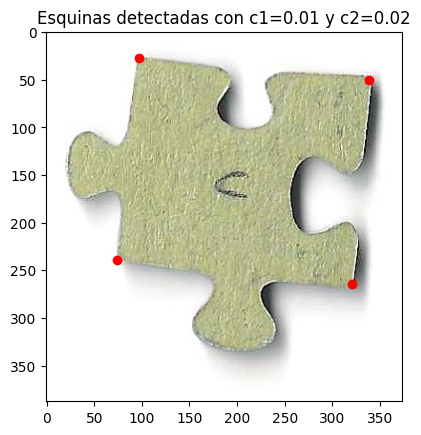

In [27]:
c1 = 0.01
c2 = 0.02
i = 2

contorno = contours[i]
corners = find_corners(contorno, c1, c2, verbose=True)
plt.imshow(back_rois[i], cmap='gray')
plt.scatter(corners[:, 0], corners[:, 1], color='red')
plt.title(f'Esquinas detectadas con c1={c1} y c2={c2}')

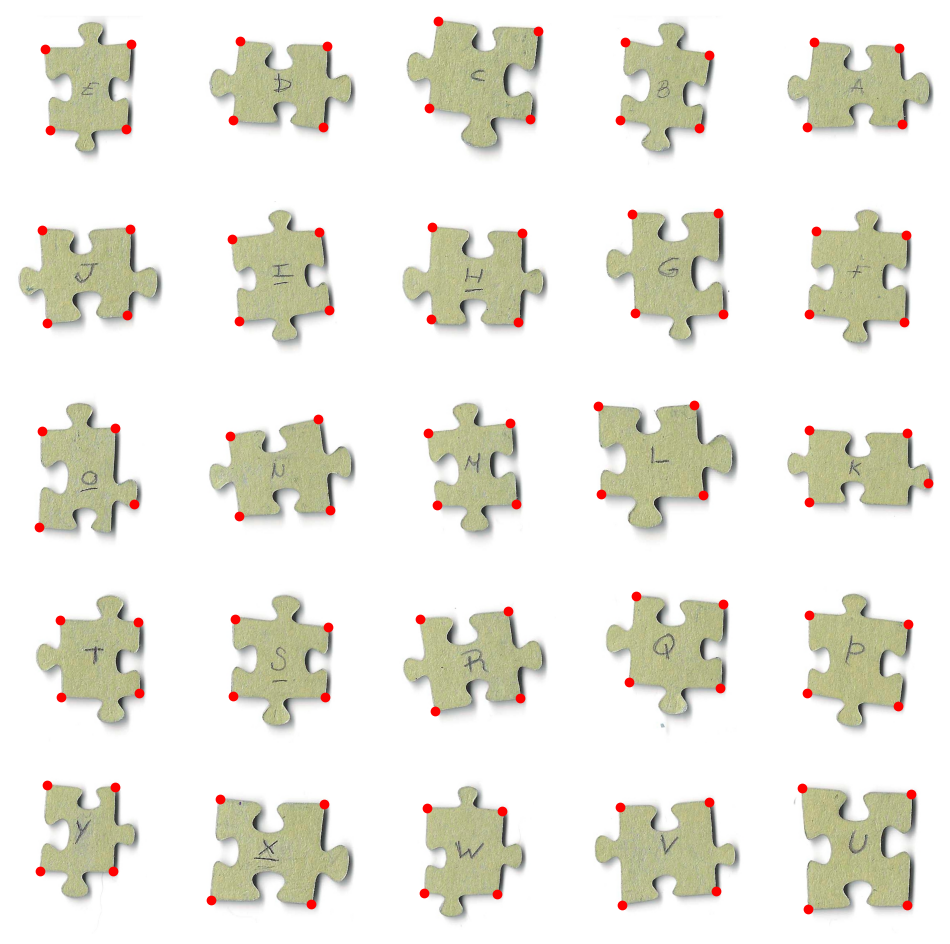

In [28]:
# Comprobamos con todos los plots:

fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.flatten()

for i in range(5):
    for j in range(5):
        index = i * 5 + j
        contour = contours[index]
        esquinas = find_corners(contour, c1, c2)

        plt.sca(ax[index])
        plt.imshow(back_rois[index], cmap='gray')
        plt.scatter(esquinas[:, 0], esquinas[:, 1], color='red')
        plt.axis('off')



In [55]:
df = pd.DataFrame(columns=['contorno', 'esquinas'])

df['contorno'] = [np.array(list(map(lambda x: (x[0]), contorno))) for contorno in contours]
df['esquinas'] = [find_corners(c, c1, c2) for c in contours]

In [62]:
df

contorno  \
0   [[155, 38], [154, 39], [149, 39], [148, 40], [...   
1   [[108, 24], [106, 26], [106, 36], [105, 37], [...   
2   [[97, 27], [96, 28], [96, 30], [94, 32], [94, ...   
3   [[151, 39], [150, 40], [139, 40], [137, 42], [...   
4   [[95, 25], [94, 26], [94, 34], [93, 35], [93, ...   
5   [[288, 29], [287, 30], [276, 30], [275, 31], [...   
6   [[156, 29], [155, 30], [153, 30], [151, 32], [...   
7   [[101, 26], [101, 28], [100, 29], [100, 55], [...   
8   [[272, 30], [271, 31], [257, 31], [256, 32], [...   
9   [[184, 28], [183, 29], [181, 29], [179, 31], [...   
10  [[122, 31], [121, 32], [117, 32], [116, 33], [...   
11  [[333, 30], [331, 32], [328, 32], [327, 33], [...   
12  [[119, 32], [117, 34], [116, 34], [115, 35], [...   
13  [[237, 29], [236, 30], [221, 30], [220, 31], [...   
14  [[84, 26], [83, 27], [83, 48], [82, 49], [82, ...   
15  [[209, 31], [208, 32], [203, 32], [202, 33], [...   
16  [[149, 35], [148, 36], [145, 36], [142, 39], [...   
17  [[273, 40], [272, 41], [269, 41], [267, 43], [...   
18  [[102, 34], [102, 36], [101, 37], [99, 37], [9...   
19  [[143, 30], [142, 31], [139, 31], [138, 32], [...   
20  [[40, 30], [42, 32], [41, 33], [41, 38], [39, ...   
21  [[42, 32], [42, 34], [41, 35], [41, 36], [40, ...   
22  [[139, 35], [138, 36], [135, 36], [134, 37], [...   
23  [[331, 34], [330, 35], [315, 35], [315, 36], [...   
24  [[23, 31], [22, 32], [20, 32], [20, 39], [21, ...   

                                          esquinas  
0   [[259, 349], [274, 100], [38, 350], [22, 113]]  
1    [[108, 24], [346, 271], [88, 251], [357, 39]]  
2     [[97, 27], [321, 264], [74, 239], [339, 50]]  
3    [[20, 309], [243, 331], [35, 89], [272, 125]]  
4     [[95, 25], [77, 263], [344, 255], [334, 40]]  
5     [[79, 32], [292, 243], [93, 264], [299, 29]]  
6    [[276, 89], [24, 110], [306, 316], [43, 350]]  
7   [[101, 26], [100, 278], [339, 287], [348, 42]]  
8     [[307, 30], [320, 289], [95, 288], [87, 33]]  
9    [[308, 100], [22, 331], [43, 88], [300, 353]]  
10   [[21, 371], [231, 98], [283, 309], [29, 105]]  
11   [[336, 30], [105, 310], [80, 77], [369, 294]]  
12   [[20, 115], [272, 318], [257, 88], [48, 321]]  
13    [[266, 239], [28, 238], [246, 30], [21, 32]]  
14    [[83, 233], [83, 27], [363, 37], [422, 179]]  
15    [[277, 97], [81, 92], [280, 276], [85, 285]]  
16   [[29, 98], [289, 122], [22, 312], [279, 315]]  
17   [[101, 292], [316, 258], [63, 60], [285, 40]]  
18   [[102, 34], [83, 267], [330, 281], [336, 56]]  
19   [[21, 309], [304, 113], [277, 345], [26, 88]]  
20    [[40, 30], [229, 278], [20, 277], [236, 36]]  
21    [[42, 32], [299, 46], [20, 281], [267, 290]]  
22   [[229, 344], [246, 104], [21, 339], [29, 95]]  
23    [[89, 49], [96, 319], [337, 36], [354, 282]]  
24    [[20, 32], [280, 45], [270, 309], [36, 319]]

In [66]:
# Guardamos el df en un csv

df.to_pickle('esquinas_detectadas.pkl')

In [29]:
for i, mask in enumerate(masks):
    #guardar imagenes
    cv.imwrite(f'fotos/segmented_scan_25/back_contours/{i:02d}.png', mask)

# Pruebas thressholding

In [30]:
# thressholding

cv.threshold(blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
plt.imshow(combined_mask, cmap='gray')

NameError: name 'blurred' is not defined

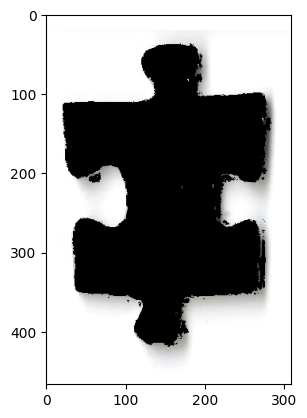

In [ ]:
blurred_hsv = cv.cvtColor(blurred, cv.COLOR_BGR2HSV)

# enmascaramos los valores ocn saturacion muy bajos para ver si son la sombre

mask_shadow = cv.inRange(blurred_hsv, (0, 0, 0), (179, 10, 255))

if mask_shadow[0,0] == 0:
    mask_shadow = cv.bitwise_not(mask_shadow)

plt.imshow(cv.cvtColor(cv.bitwise_and(blurred, blurred, mask=mask_shadow), cv.COLOR_BGR2RGB), cmap='gray')


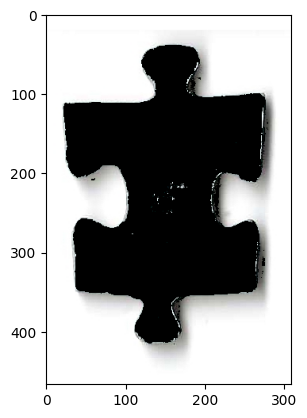

In [ ]:
blurred_hsv = cv.cvtColor(blurred, cv.COLOR_BGR2HSV)

lower_cyan = np.array([30, 20, 50])
upper_cyan = np.array([150, 255, 255])

mask_shadow = cv.inRange(blurred_hsv, lower_cyan, upper_cyan)

if mask_shadow[0,0] == 0:
    mask_shadow = cv.bitwise_not(mask_shadow)

plt.imshow(cv.cvtColor(cv.bitwise_and(blurred, blurred, mask=mask_shadow), cv.COLOR_BGR2RGB), cmap='gray')

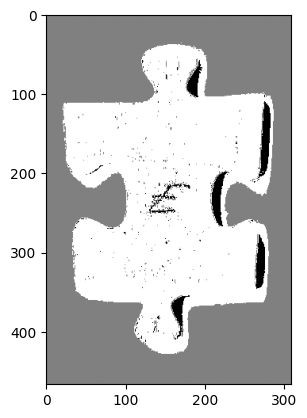

In [ ]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
blurred_reshaped = blurred.reshape((-1, 3)).astype(np.float32)
_, labels, centers = cv.kmeans(blurred_reshaped, 3, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

mask = labels.reshape(blurred.shape[:2])

if mask[0,0] == 0:
    mask = cv.bitwise_not(mask)

plt.imshow(mask, cmap='gray')

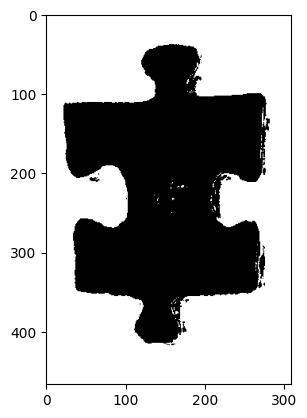

In [ ]:
combined_mask = cv.bitwise_or(mask.astype(np.uint8), mask_shadow)
plt.imshow(combined_mask, cmap='gray')

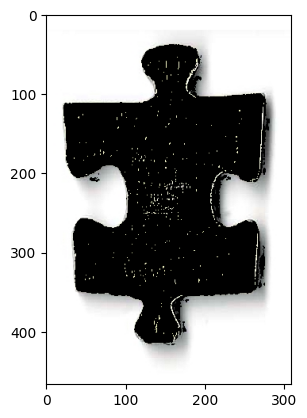

In [ ]:
plt.imshow(cv.bitwise_and(blurred, blurred, mask=combined_mask), cmap='gray')

## CANNY

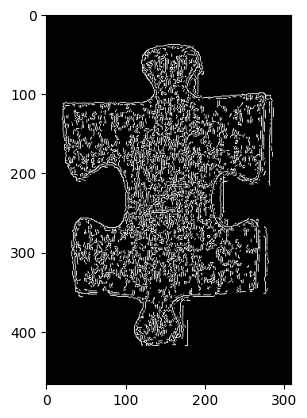

In [ ]:
edges = cv.Canny(blurred, 100, 150)
plt.imshow(edges, cmap='gray')